In [7]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import imshow
%matplotlib inline

In [5]:
path_ffhq       = './pretrained/karras2019stylegan-ffhq-1024x1024.pkl'
path_celebahq   = './pretrained/karras2019stylegan-celebahq-1024x1024.pkl'
path_bedrooms   = './pretrained/karras2019stylegan-bedrooms-256x256.pkl'
path_cars       = './pretrained/karras2019stylegan-cars-512x384.pkl'
path_cats       = './pretrained/karras2019stylegan-cats-256x256.pkl'

synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

_Gs_cache = dict()

# def load_Gs(url):
#     if url not in _Gs_cache:
#         with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
#             _G, _D, Gs = pickle.load(f)
#         _Gs_cache[url] = Gs
#     return _Gs_cache[url]

def load_Gs(path):
    if path not in _Gs_cache:
        fr = open(path,'rb')
        _G, _D, Gs = pickle.load(fr)
        _Gs_cache[path] = Gs
    return _Gs_cache[path]

In [15]:
# Style mixing.

def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    print(png)
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    dst_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in dst_seeds)
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_seeds) + 1), h * (len(dst_seeds) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)
    imshow(np.asarray(canvas))

results/figure03-style-mixing.png


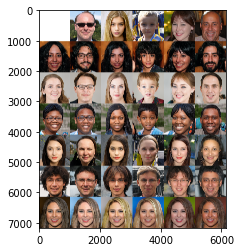

In [16]:
tflib.init_tf()
warnings.filterwarnings('ignore')
os.makedirs(config.result_dir, exist_ok=True)
draw_style_mixing_figure(os.path.join(config.result_dir, 'figure03-style-mixing.png'), load_Gs(path_ffhq), 
                         w=1024, h=1024, src_seeds=[639,701,687,615,2268], dst_seeds=[888,829,1898,1733,1614,845], 
                         style_ranges=[range(0,4)]*3+[range(4,8)]*2+[range(8,18)])